In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### 데이터셋 로드

In [1]:
csv_url = "https://raw.githubusercontent.com/MyungKyuYi/AI-class/main/AAME.csv"
df = pd.read_csv(csv_url)

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-03-17,0.0,4.05,3.85,3.85,3.213167,15000
1,1980-03-18,0.0,4.00,3.80,3.80,3.171437,10200
2,1980-03-19,0.0,4.05,3.85,3.85,3.213167,33500
3,1980-03-20,0.0,4.00,3.80,3.80,3.171437,8700
4,1980-03-21,0.0,3.95,3.75,3.75,3.129709,12700


In [3]:
# 제거할 컬럼 이름 지정
columns_to_drop = ['Date', 'Adj Close', 'Volume']

# 컬럼 제거
df = df.drop(columns=columns_to_drop)

df.head()

,Open,High,Low,Close
0,0.0,4.05,3.85,3.85
1,0.0,4.00,3.80,3.80
2,0.0,4.05,3.85,3.85
3,0.0,4.00,3.80,3.80
4,0.0,3.95,3.75,3.75


In [4]:
openValues = df[['Open']].values

### 특징값 정규화

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0, 1))
scaled = scaler.fit_transform(openValues)

### 훈련 데이터와 테스트 데이터의 분리

In [6]:
TEST_SIZE = 200
train_data = scaled[:-TEST_SIZE]
test_data = scaled[-TEST_SIZE:]

### 순차 훈련 데이터를 생성

In [7]:
def make_sample(data, window):
  train = []
  target = []
  for i in range(len(data)-window):
    train.append(data[i:i+window])
    target.append(data[i+window])
  return np.array(train), np.array(target)

X_train, y_train = make_sample(train_data, 30)

### LSTM 구축하기

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

model = Sequential()
model.add(LSTM(16,
               input_shape = (X_train.shape[1], 1),
               activation = 'tanh',
               return_sequences = False)
        )
model.add(Dense(1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### 모델 학습

In [9]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=100, batch_size= 16)

Epoch 1/100
617/617 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0126
Epoch 2/100
617/617 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0030
Epoch 3/100
617/617 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0026
Epoch 4/100
617/617 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0023
Epoch 5/100
617/617 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0027
Epoch 6/100
617/617 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0026
Epoch 7/100
617/617 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0028
Epoch 8/100
617/617 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0024
Epoch 9/100
617/617 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0025
Epoch 10/100
617/617 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0027
Epoch 11/100
617/617 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0024
Epoch 12/100
617/617 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0021
Epoch 13/100
617/617 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0023
Epoch 14/100
617/617 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0025
Epoch 15/100
617/617 ━━━━━━━━━━━━━━━━━━━━ 3

### 테스트셋을 이용하여 미래 주가 예측

In [10]:
X_test, y_test = make_sample(test_data, 30)
pred = model.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


### 그래프 그리기

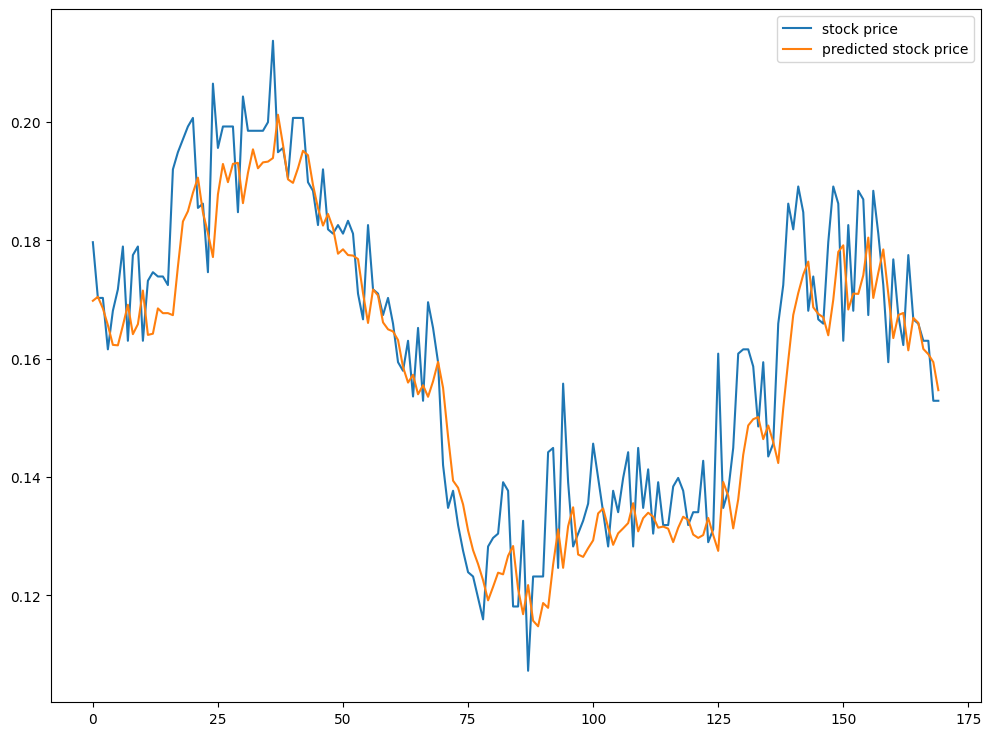

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 9))
plt.plot(y_test, label = 'stock price')
plt.plot(pred, label = 'predicted stock price')
plt.legend()
plt.show()

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 예측
pred = model.predict(X_test)

# 스케일 복원 (inverse transform)
# pred와 y_test는 모두 MinMaxScaler로 0~1 사이 값이므로 원래 값으로 복원
pred_rescaled = scaler.inverse_transform(pred)
y_test_reshaped = y_test.reshape(-1, 1)
y_test_rescaled = scaler.inverse_transform(y_test_reshaped)

# 성능 지표 계산
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape(y_true, y_pred):
    return 100 / len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

mse = mean_squared_error(y_test_rescaled, pred_rescaled)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_rescaled, pred_rescaled)
r2 = r2_score(y_test_rescaled, pred_rescaled)
mape = mean_absolute_percentage_error(y_test_rescaled, pred_rescaled)
smape_score = smape(y_test_rescaled, pred_rescaled)

print(f"LSTM 성능")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R^2 Score: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"SMAPE: {smape_score:.2f}%")


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
LSTM 성능
Mean Squared Error (MSE): 0.0221
Root Mean Squared Error (RMSE): 0.1486
Mean Absolute Error (MAE): 0.1163
R^2 Score: 0.8094
MAPE: 5.20%
SMAPE: 5.36%


### RNN (SimpleRNN) 모델 정의 및 학습

In [13]:
from tensorflow.keras.layers import SimpleRNN

model_rnn = Sequential()
model_rnn.add(SimpleRNN(16, input_shape=(X_train.shape[1], 1), activation='tanh', return_sequences=False))
model_rnn.add(Dense(1))
model_rnn.compile(optimizer='adam', loss='mean_squared_error')
model_rnn.fit(X_train, y_train, epochs=100, batch_size=16)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


617/617 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0243
Epoch 2/100
617/617 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0035
Epoch 3/100
617/617 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0026
Epoch 4/100
617/617 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0029
Epoch 5/100
617/617 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0024
Epoch 6/100
617/617 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0025
Epoch 7/100
617/617 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0033
Epoch 8/100
617/617 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0027
Epoch 9/100
617/617 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0025
Epoch 10/100
617/617 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0031
Epoch 11/100
617/617 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0025
Epoch 12/100
617/617 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0023
Epoch 13/100
617/617 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0025
Epoch 14/100
617/617 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0029
Epoch 15/100
617/617 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step -

In [ ]:
# RNN 예측 및 스케일 복원
pred_rnn = model_rnn.predict(X_test)
pred_rnn_rescaled = scaler.inverse_transform(pred_rnn)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 294ms/step


In [ ]:
# RNN 성능 평가
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape(y_true, y_pred):
    return 100 / len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

mse = mean_squared_error(y_test_rescaled, pred_rnn_rescaled)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_rescaled, pred_rnn_rescaled)
r2 = r2_score(y_test_rescaled, pred_rnn_rescaled)
mape = mean_absolute_percentage_error(y_test_rescaled, pred_rnn_rescaled)
smape_score = smape(y_test_rescaled, pred_rnn_rescaled)

print(f"RNN 성능")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R^2 Score: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"SMAPE: {smape_score:.2f}%")


RNN 성능
Mean Squared Error (MSE): 0.0183
Root Mean Squared Error (RMSE): 0.1354
Mean Absolute Error (MAE): 0.1085
R^2 Score: 0.8417
MAPE: 4.94%
SMAPE: 4.98%


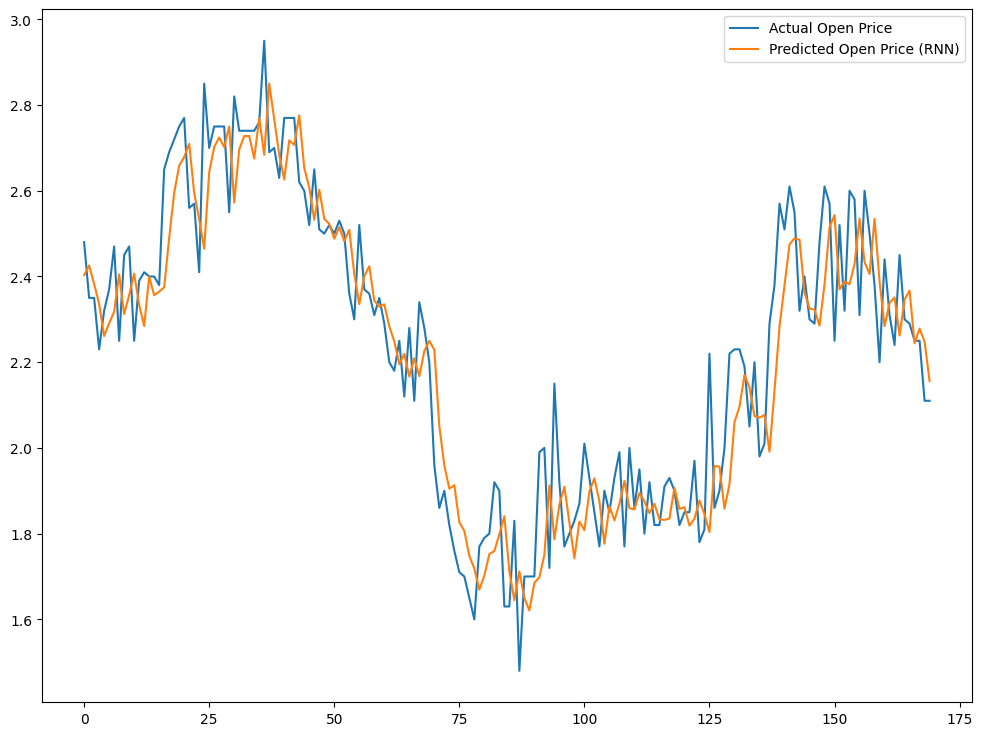

In [ ]:
# RNN 결과 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 9))
plt.plot(y_test_rescaled, label='Actual Open Price')
plt.plot(pred_rnn_rescaled, label='Predicted Open Price (RNN)')
plt.legend()
plt.show()

### LSTM vs RNN 한 그래프 비교 코드

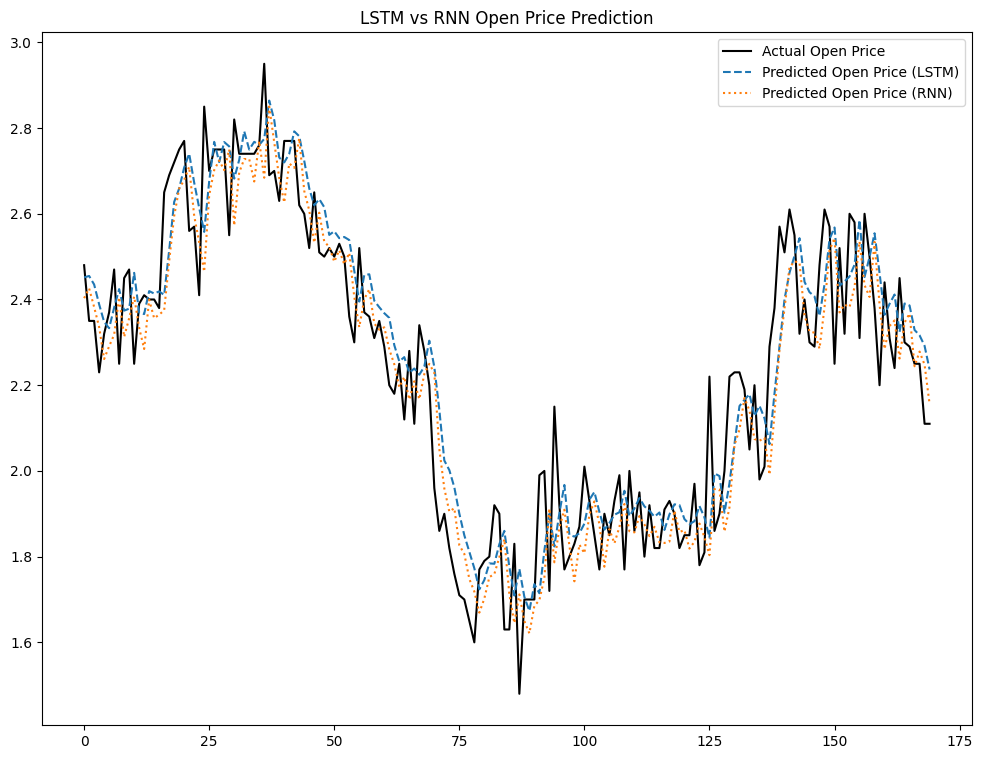

In [ ]:
plt.figure(figsize=(12, 9))
plt.plot(y_test_rescaled, label='Actual Open Price', color='black')
plt.plot(pred_rescaled, label='Predicted Open Price (LSTM)', linestyle='--')
plt.plot(pred_rnn_rescaled, label='Predicted Open Price (RNN)', linestyle=':')
plt.legend()
plt.title('LSTM vs RNN Open Price Prediction')
plt.show()